<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/LSTM_Apple_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.551519628999813
GPU (s):
0.2513316529984877
GPU speedup over CPU: 14x


In [0]:
%cd /gdrive
%ls

/gdrive
'My Drive'/


<font color=red size=6> Import Libraries & Process Data </font>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset_training = pd.read_excel('My Drive/MyLearning/MLDLAIPython/Data/TextData/APPL_Stock_Data_2009thru2019.xlsx',0)
dataset_training.head()


,date,open,high,low,close,volume
0,2009-01-02,12.2686,13.0057,12.1657,12.9643,186503800
1,2009-01-05,13.3100,13.7400,13.2443,13.5114,295402100
2,2009-01-06,13.7071,13.8814,13.1986,13.2886,322327600
3,2009-01-07,13.1157,13.2143,12.8943,13.0014,188262200
4,2009-01-08,12.9186,13.3071,12.8629,13.2429,168375200


In [0]:
training_data = dataset_training.iloc[:, 1:2].values
training_data

array([[ 12.2686],
       [ 13.31  ],
       [ 13.7071],
       ...,
       [191.545 ],
       [192.9   ],
       [196.05  ]])

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_data_scaled = sc.fit_transform(training_data)

training_data_scaled 

array([[0.0041863 ],
       [0.00893223],
       [0.01074192],
       ...,
       [0.82119583],
       [0.82737092],
       [0.84172629]])

# Create Data Time Stamps & Rehape the Data

In [0]:
# ALl the predictions will be based on the past 60 timestamps and the process will be followed subsequently

X_train = []
y_train = []
for i in range(60, 2632):
    X_train.append(training_data_scaled[i-60:i, 0])
    y_train.append(training_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.0041863 ],
        [0.00893223],
        [0.01074192],
        ...,
        [0.01847651],
        [0.01873673],
        [0.016315  ]],

       [[0.00893223],
        [0.01074192],
        [0.00804676],
        ...,
        [0.01873673],
        [0.016315  ],
        [0.01692704]],

       [[0.01074192],
        [0.00804676],
        [0.00714852],
        ...,
        [0.016315  ],
        [0.01692704],
        [0.01604156]],

       ...,

       [[0.79697398],
        [0.814246  ],
        [0.83849063],
        ...,
        [0.83630315],
        [0.83215604],
        [0.83557399]],

       [[0.814246  ],
        [0.83849063],
        [0.82103632],
        ...,
        [0.83215604],
        [0.83557399],
        [0.82119583]],

       [[0.83849063],
        [0.82103632],
        [0.82173814],
        ...,
        [0.83557399],
        [0.82119583],
        [0.82737092]]])

In [0]:
X_train.shape

(2572, 60, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [0]:
model = Sequential()
#When you add multiple layers then set the return sequences as true
# in the input shape the 1st dim is taken by LSTM as default 
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.3))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.3))


# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.3))

# Last input layer return sequence not needed
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
#model.add(Dropout(0.3))

# Adding the output layer
model.add(Dense(units = 1))

In [0]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
2572/2572 [==============================] - 42s 16ms/step - loss: 0.0140
Epoch 2/100
2572/2572 [==============================] - 39s 15ms/step - loss: 8.9650e-04
Epoch 3/100
2572/2572 [==============================] - 39s 15ms/step - loss: 8.5581e-04
Epoch 4/100
2572/2572 [==============================] - 39s 15ms/step - loss: 8.1155e-04
Epoch 5/100
2572/2572 [==============================] - 39s 15ms/step - loss: 7.3701e-04
Epoch 6/100
2572/2572 [==============================] - 39s 15ms/step - loss: 6.5762e-04
Epoch 7/100
2572/2572 [==============================] - 39s 15ms/step - loss: 5.5584e-04
Epoch 8/100
2572/2572 [==============================] - 39s 15ms/step - loss: 6.3455e-04
Epoch 9/100
2572/2572 [==============================] - 39s 15ms/step - loss: 4.9641e-04
Epoch 10/100
2572/2572 [==============================] - 39s 15ms/step - loss: 5.5485e-04
Epoch 11/100
2572/2572 [==============================] - 39s 15ms/step - loss: 6.0153e-04
Epoch 12/100

In [0]:
dataset_testing = pd.read_excel("My Drive/MyLearning/MLDLAIPython/Data/TextData/APPL_Stock_Test_2019_Apr_Jun.xlsx", 0)
actual_stock_price = dataset_testing.iloc[:, 1:2].values
#actual_stock_price.head(10)

In [0]:
total_data = pd.concat((dataset_training['open'], dataset_testing['open']), axis = 0)
inputs = total_data[len(total_data) - len(dataset_testing) - 60:].values

print ('len(total_data)---->', len(total_data))
print ('len(dataset_testing)---->', len(dataset_testing))

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 151):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
#Inverse scale is used to unscale the data
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

len(total_data)----> 2722
len(dataset_testing)----> 90


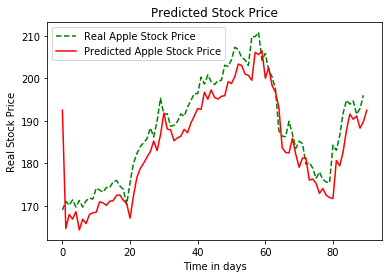

In [0]:
# Visualising the results
plt.plot(actual_stock_price, color = 'green', label = 'Real Apple Stock Price',ls='--')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Apple Stock Price',ls='-')
plt.title('Predicted Stock Price')
plt.xlabel('Time in days')
plt.ylabel('Real Stock Price')
plt.legend()
plt.show()